## Lib & Data Import 


In [4]:
import tensorflow as tf 
import tensorflow_hub as hub 
from tensorflow.keras import layers 
import re 
# re — Regular expression operations
import math
import csv
import pandas as pd                     
import cv2 as cv 
from tensorflow.keras import losses
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from google.colab import drive
# os — Miscellaneous operating system interfaces
import os 
from PIL import Image, ImageSequence
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.chdir('/content/drive/Shareddrives/Animated Gif/GIF models/redditgif')
!pwd

/content/drive/Shareddrives/Animated Gif/GIF models/redditgif


In [7]:
# read in reddit dataset
r_data = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/reddit_data_complete_processed.csv")
r_data.head(2)
len(r_data)

5744

In [ ]:
# read in twitter dataset
#t_data = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/twitterWeekdayData.csv")
#t_data.head(2)

## Text Data Preprocess

### Text Cleaning

run this section first to define text cleaning function

In [8]:
# definition for function for removing html tags 
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:
# definition for function for remove any punctuations and special characters
def preprocess_single_text(raw_tweet):
    # Removing html tags
    sentence = remove_tags(raw_tweet)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [10]:
# run the preprocess_text function to clean tweets list 
def clean_text(data, colname):
  x = []
  for entry in data[colname]:
    x.append(preprocess_single_text(entry))
  return x


### Tokenizing With Bert
Note: In the previous code we used Bert from tensorflow but here we used Bert from Pytorch

In [ ]:
xr[0].values

array(['MRW suffer from depression and the interviewer asks what are my interests outside of work',
       'MRW m in the waiting room at the sperm bank',
       'MRW coworker hopes that work gets busy ', ...,
       'MRW the neighbor is having party',
       'MRW my Ex says that the new Netflix password isn working',
       'MRW m watching two extremely good ping pong players xpost shittyreactiongifs '],
      dtype=object)

In [ ]:
max_fatures = 200
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(xr[0].values)
X = tokenizer.texts_to_sequences(xr[0].values)
tokenized_xr = pad_sequences(X)

In [ ]:
tokenized_xr

array([[  0,   0,   0, ...,   3,   9,  46],
       [  0,   0,   0, ...,   2,  16,   2],
       [  0,   0,   0, ...,  15,  46,  88],
       ...,
       [  0,   0,   0, ...,   2,  14, 180],
       [  0,   0,   0, ...,  15,   2,  44],
       [  0,   0,   0, ...,  10,  89, 136]], dtype=int32)

### Bag of Word Tokenization

In [12]:
import heapq
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') 

def extract_text(s):    
    stop_words = set(stopwords.words('english'))  #pending more stop words    
    words = re.sub("[^\w]", " ",  s).split()    
    extracted = [w.lower() for w in words if w not in stop_words]    
    return extracted
def init_bag_dict(x):
    bag = {}
    x = list(set(x))
    for entry in x:
        new_words = extract_text(entry)
        for word in new_words:
            if word not in bag.keys():
                bag[word] = 1
            else:
                bag[word] += 1
    return bag
def tokenize(x, bag, d=300):
    most_freq = heapq.nlargest(d, bag, key=bag.get)
    vectorized_x = []
    for entry in x:
        curr_bag = np.zeros(len(most_freq))
        extracted_text = extract_text(entry)
        for i, token in enumerate(most_freq):
            curr_bag[i] = extracted_text.count(token)
        vectorized_x.append(curr_bag)
    vectorized_x = np.asarray(vectorized_x)
    return vectorized_x, most_freq

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
xr = clean_text(r_data, colname="text")

bag = init_bag_dict(xr)


In [17]:
most_freq = heapq.nlargest(5000, bag, key=bag.get)
most_freq

['mrw',
 'see',
 'someone',
 'when',
 'get',
 'says',
 'asks',
 'time',
 'post',
 'friend',
 'reaction',
 'people',
 'my',
 'new',
 'work',
 'go',
 'first',
 'tells',
 'reddit',
 'trump',
 'wife',
 'realize',
 'day',
 'one',
 'hear',
 'find',
 'finally',
 'like',
 'the',
 'back',
 'going',
 'gets',
 'watching',
 'ask',
 'something',
 'home',
 'friends',
 'still',
 'trying',
 'year',
 'want',
 'starts',
 'old',
 'girl',
 'make',
 'front',
 'game',
 'try',
 'got',
 'getting',
 'last',
 'another',
 'start',
 'comment',
 'say',
 'know',
 'tell',
 'years',
 'girlfriend',
 'next',
 'guy',
 'mfw',
 'gif',
 'read',
 'two',
 'boss',
 'show',
 'posts',
 'come',
 'minutes',
 'movie',
 'house',
 'phone',
 'watch',
 'check',
 'rw',
 'food',
 'night',
 'today',
 'page',
 'morning',
 'take',
 'news',
 'think',
 'every',
 'really',
 'talking',
 'use',
 'shit',
 'person',
 'mom',
 'everyone',
 'need',
 'comes',
 'comments',
 'right',
 'look',
 'video',
 'open',
 'long',
 'car',
 'family',
 'us',
 'week

In [19]:
num_of_feature = 200
tokenized_xr, most_freq = tokenize(xr, bag, d=num_of_feature) 

In [20]:
most_freq

['mrw',
 'see',
 'someone',
 'when',
 'get',
 'says',
 'asks',
 'time',
 'post',
 'friend',
 'reaction',
 'people',
 'my',
 'new',
 'first',
 'work',
 'go',
 'tells',
 'reddit',
 'trump',
 'wife',
 'day',
 'realize',
 'one',
 'hear',
 'find',
 'finally',
 'like',
 'the',
 'back',
 'going',
 'watching',
 'gets',
 'ask',
 'something',
 'home',
 'still',
 'friends',
 'year',
 'trying',
 'want',
 'starts',
 'old',
 'girl',
 'make',
 'front',
 'game',
 'try',
 'got',
 'getting',
 'last',
 'start',
 'another',
 'comment',
 'say',
 'know',
 'tell',
 'years',
 'girlfriend',
 'next',
 'guy',
 'gif',
 'mfw',
 'read',
 'two',
 'posts',
 'show',
 'come',
 'boss',
 'minutes',
 'movie',
 'phone',
 'house',
 'watch',
 'check',
 'rw',
 'food',
 'night',
 'today',
 'page',
 'morning',
 'take',
 'think',
 'every',
 'news',
 'really',
 'shit',
 'talking',
 'use',
 'mom',
 'person',
 'need',
 'everyone',
 'comments',
 'comes',
 'right',
 'look',
 'video',
 'open',
 'car',
 'family',
 'long',
 'us',
 'mr',

### TFIDF Tokenization 

In [20]:
corpus = []
for x in xr:
  corpus.append(x)

corpus

['MRW suffer from depression and the interviewer asks what are my interests outside of work',
 'MRW m in the waiting room at the sperm bank',
 'MRW coworker hopes that work gets busy ',
 'MRW police officer says that if journalists don want to get beat they should report news and not opinions lies and agendas ',
 'QAnon RW Ivanka Trump posts pic of her getting the vaccine and feel like it an act of betrayal',
 'MRW check on the funny meme made last night and it only has upvotes ',
 'MRW my girlfriend gives me birthday gifts and can help but think about how those gifts will remind me of her if she would break up with me',
 'MRW it April and it been snowing all morning',
 'MRW my best friend is about to ask his crush out on date',
 'MRW go to order food but the website won take my card so have to go get cash instead',
 'MRW it super busy at work and my shift is over',
 'MRW hear Lady Dimitrescu the tall woman in Resident Evil chases and threatens to punish you throughout the whole game',

In [48]:
# TfidfVectorizer 
# CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

# list of text documents

def extract_text_tfid(s):    
    stop_words = set(stopwords.words('english'))  #pending more stop words    
    words = re.sub("[^\w]", " ",  s).split()    
    extracted = [w for w in words if w not in stop_words]    
    return extracted
  

vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(corpus)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)


# encode document
vector = vectorizer.transform([corpus[0]])
# summarize encoded vector
print(vector)
print(vector.shape)
print(vector.toarray())

tokenized_x = []
for x in xr:
  vector = vectorizer.transform([x])
  tokenized_x.append(vector.toarray()[0])


# # settings that you use for count vectorizer will go here 
# tfidf_vectorizer=TfidfVectorizer(use_idf=True) 
 
# # just send in all your docs here 
# tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(corpus)

# # get the first vector out (for the first document) 
# first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] 
 
# # place tf-idf v# place tf-idf values in a pandas data frame 
# df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
# df.sort_values(by=["tfidf"],ascending=False)

{'mrw': 4683, 'suffer': 7028, 'from': 2919, 'depression': 1976, 'and': 234, 'the': 7294, 'interviewer': 3711, 'asks': 400, 'what': 8026, 'are': 351, 'my': 4723, 'interests': 3695, 'outside': 5046, 'of': 4929, 'work': 8148, 'in': 3587, 'waiting': 7906, 'room': 6152, 'at': 434, 'sperm': 6780, 'bank': 583, 'coworker': 1706, 'hopes': 3443, 'that': 7293, 'gets': 3031, 'busy': 1022, 'police': 5382, 'officer': 4938, 'says': 6254, 'if': 3544, 'journalists': 3864, 'don': 2181, 'want': 7925, 'to': 7415, 'get': 3030, 'beat': 644, 'they': 7317, 'should': 6503, 'report': 5955, 'news': 4806, 'not': 4852, 'opinions': 4993, 'lies': 4156, 'agendas': 125, 'qanon': 5668, 'rw': 6196, 'ivanka': 3772, 'trump': 7568, 'posts': 5451, 'pic': 5270, 'her': 3347, 'getting': 3032, 'vaccine': 7787, 'feel': 2674, 'like': 4167, 'it': 3761, 'an': 228, 'act': 48, 'betrayal': 704, 'check': 1259, 'on': 4969, 'funny': 2945, 'meme': 4469, 'made': 4296, 'last': 4034, 'night': 4817, 'only': 4977, 'has': 3286, 'upvotes': 7756,

In [50]:
tokenized_x[1].shape

(8261,)

### Put together

In [ ]:
# This is legacy code. reddit data has now been pre-processed. 
# save data length
# use only data with gif
# r_data = r_data[r_data['filenames'].str.contains(".gif")]
# rlen = len(r_data)
#tlen = len(t_data)
# r_data.head()

In [15]:
xr = clean_text(r_data, colname="text")
#xt = clean_text(t_data, colname="Tweet Text")

In [ ]:
xr.iloc[1]
xr

,0
0,MRW suffer from depression and the interviewer...
1,MRW m in the waiting room at the sperm bank
2,MRW coworker hopes that work gets busy
3,MRW police officer says that if journalists do...
4,QAnon RW Ivanka Trump posts pic of her getting...
...,...
5739,MRW when Mom says she going to give me timeout...
5740,MRW people think my dog is female
5741,MRW the neighbor is having party
5742,MRW my Ex says that the new Netflix password i...


In [ ]:
#raw text vector tokenized with Bert without padding
#tokenized_xr = [tokenize_tweets(tweet) for tweet in xr]
#tokenized_xt = [tokenize_tweets(tweet) for tweet in xt]


In [ ]:
print(xr[1])
len(xr)

MRW m in the waiting room at the sperm bank


5744

## Visual Data Preprocess
 This section contains code to remove corrupted files


### Gif Files Adjustment

In [ ]:
import imageio
import os, sys

class TargetFormat(object):
    GIF = ".gif"
    MP4 = ".mp4"
    AVI = ".avi"

def convertFile(inputpath, targetFormat):
    """Reference: http://imageio.readthedocs.io/en/latest/examples.html#convert-a-movie"""
    outputpath = os.path.splitext(inputpath)[0] + targetFormat
    print("converting\r\n\t{0}\r\nto\r\n\t{1}".format(inputpath, outputpath))

    reader = imageio.get_reader(inputpath)
    fps = reader.get_meta_data()['fps']

    writer = imageio.get_writer(outputpath, fps=fps)
    for i,im in enumerate(reader):
        sys.stdout.write("\rframe {0}".format(i))
        sys.stdout.flush()
        writer.append_data(im)
    print("\r\nFinalizing...")
    writer.close()
    print("Done.")

converting
	mt4iov.mp4
to
	mt4iov.gif
frame 112
Finalizing...
Done.


In [ ]:
print(r_data[r_data['filenames'].str.contains("2r96lr.gif")])
r_data = r_data.drop(10238)
print(r_data[r_data['filenames'].str.contains("2r96lr")])
len(r_data)
r_data.to_csv("/content/drive/Shareddrives/Animated Gif/GIF models/reddit_data_cleaned.csv")

Empty DataFrame
Columns: [Unnamed: 0, title, url, full_link, filenames]
Index: []


KeyError: ignored

In [ ]:
cor = ['2r96lr.gif',
 '2s11ep.gif',
 '2tkdxa.gif',
 '2ud0nt.gif',
 '2ud3ss.gif',
 '2wpccl.gif',
 '2wpx9g.gif',
 '2z3034.gif',
 '34n2ko.gif',
 '366kpl.gif',
 '36zmy0.gif',
 '3bcxcm.gif',
 '3ivbmr.gif',
 '3ljx6x.gif',
 '3lk9ye.gif',
 '3q1wdu.gif',
 '3ss50v.gif',
 '3vkutt.gif',
 '418td5.gif',
 '45lnnf.gif',
 '45n7iv.gif',
 '46pzxy.gif',
 '46q38r.gif',
 '46qf34.gif',
 '4a4irv.gif',
 '4b31d0.gif',
 '4e14md.gif',
 '4e2o1w.gif',
 '4h3ik0.gif',
 '4qzkx4.gif',
 '51z5ik.gif',
 '59wyle.gif',
 '5hh0xz.gif',
 '5l8dx9.gif',
 '5mk1eb.gif']
for str1 in cor:
  print(r_data[r_data['filenames'].str.contains(str1)])

In [ ]:

brightness = []
i = 0
for idx in reversed(r_data.index): 
    gif_file_path = r_data['filenames'][idx]
    #Image.open(gif_file_path)
    brightness.append(calculate_gif_brightness(gif_file_path))
    i = i+1
    print(gif_file_path)


Streaming output truncated to the last 5000 lines.
3lke14.gif
3lkfw4.gif
3lkkka.gif
3lkl6s.gif
3ll7j1.gif
3llbms.gif
3llitz.gif
3llqej.gif
3lluti.gif
3llvd1.gif
3lm4xo.gif
3lm94f.gif
3lmlqx.gif
3lmqqe.gif
3lmv5w.gif
3mgwsu.gif
3mh6g7.gif
3mh8g6.gif
3mhfkb.gif
3mhfn1.gif
3mhibf.gif
3mht55.gif
3mi8m7.gif
3mieo8.gif
3mir6h.gif
3mja3i.gif
3mjanx.gif
3mjc77.gif
3mjj74.gif
3ncjoq.gif
3ncl8k.gif
3ncohl.gif
3ncs5x.gif
3ncsh4.gif
3ncta2.gif
3nctjc.gif
3nczcn.gif
3nd1a2.gif
3nd4jv.gif
3ndpmf.gif
3ne0t0.gif
3ne39y.gif
3ne8l5.gif
3nedeo.gif
3nenbb.gif
3nerhp.gif
3neuta.gif
3nevds.gif
3o6ud5.gif
3o6x7c.gif
3o7pbo.gif
3o88bq.gif
3o88nu.gif
3o8py1.gif
3o8qdy.gif
3o8s97.gif
3o8zjc.gif
3o90b5.gif
3o966m.gif
3o9g94.gif
3o9pn8.gif
3oa330.gif
3oa8fm.gif
3oacp8.gif
3p3s2h.gif
3p3z62.gif
3p4dcb.gif
3p4dz9.gif
3p4hhx.gif
3p4xns.gif
3p53oq.gif
3p5uwd.gif
3p5v4d.gif
3p5vma.gif
3p64tw.gif
3p673o.gif
3p6aix.gif
3p6czh.gif
3p6pd3.gif
3p6pih.gif
3q0yux.gif
3q19id.gif
3q19ut.gif
3q1f7g.gif
3q1fd9.gif
3q1h1r.gif
3q1

In [ ]:
r_data['filenames'][1:]

2        msz066.gif
3        msyt6a.gif
4        msy15j.gif
5        mssnzt.gif
6        msq42g.gif
            ...    
10281    2r91p9.gif
10282    2r8ynj.gif
10283    2r8x12.gif
10284    2r8uwx.gif
10285    2r8uhu.gif
Name: filenames, Length: 5782, dtype: object

### Gif Data Process



In [ ]:
brightness = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/redditgif/reddit_data_brightness")
brightness

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,title,url,full_link,filenames,brightness
0,0,1,1,MRW I suffer from depression and the interview...,https://i.imgur.com/9TDBvYI.gif,https://www.reddit.com/r/reactiongifs/comments...,mt0nqt.gif,0.173433
1,1,2,2,MRW I'm in the waiting room at the sperm bank,https://i.redd.it/l6438iocsst61.gif,https://www.reddit.com/r/reactiongifs/comments...,msz066.gif,0.119948
2,2,3,3,"MRW a coworker hopes that ""work gets busy.""",https://i.redd.it/c00pwf5fqst61.gif,https://www.reddit.com/r/reactiongifs/comments...,msyt6a.gif,0.217824
3,3,4,4,MRW a police officer says that if journalists ...,https://i.imgur.com/a8c4Jmc.gif,https://www.reddit.com/r/reactiongifs/comments...,msy15j.gif,0.372015
4,4,5,5,QAnon's RW Ivanka Trump posts a pic of her get...,https://i.imgur.com/0OZFJJ6.gif,https://www.reddit.com/r/reactiongifs/comments...,mssnzt.gif,0.316349
...,...,...,...,...,...,...,...,...
5739,5739,10281,10281,MRW when Mom says she's going to give me a tim...,http://media.giphy.com/media/5xaOcLxLD0RrITiGj...,https://www.reddit.com/r/reactiongifs/comments...,2r91p9.gif,0.227691
5740,5740,10282,10282,MRW people think my dog is a female,http://i.imgur.com/54HvifL.gif,https://www.reddit.com/r/reactiongifs/comments...,2r8ynj.gif,0.340756
5741,5741,10283,10283,MRW the neighbor is having a party,http://i.imgur.com/HrlWscd.gif,https://www.reddit.com/r/reactiongifs/comments...,2r8x12.gif,0.772699
5742,5742,10284,10284,MRW my Ex says that the new Netflix password i...,http://i.imgur.com/et54mtQ.gif,https://www.reddit.com/r/reactiongifs/comments...,2r8uwx.gif,0.407041


In [ ]:

combined = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/gifdata/number_of_pixels.csv")
combined['sharpness'] = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/gifdata/sharpness.csv")['sharpness']
combined['face_count'] = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/gifdata/face_count.csv")['face_count']
combined['entropy'] = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/gifdata/entropy.csv")['entropy']
combined['contrast'] = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/gifdata/contrast.csv")['contrast']
combined['framerates'] = pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/gifdata/framerates.csv")['framerates']

combined_clean = combined[combined['number_of_pixels'].notna()]
combined_clean['brightness'] = brightness['brightness']
for i, n in enumerate(brightness['brightness']):
  combined_clean['brightness'].iloc[i] = n

combined_clean['text'] = brightness['title']
for i, t in enumerate(brightness['title']):
   combined_clean['text'].iloc[i] = t


combined_clean['filenames'] = brightness['filenames']
for i, t in enumerate(brightness['filenames']):
   combined_clean['filenames'].iloc[i] = t
#combined_clean['brightness'] = brightness['brightness']
#combined_clean['text'] = brightness['title']
#npixel = pixel[pixel['number_of_pixels'].notna()]
#npixel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykern

In [ ]:
combined_clean.to_csv("/content/drive/Shareddrives/Animated Gif/GIF models/reddit_data_complete_processed.csv")

In [ ]:
pd.read_csv("/content/drive/Shareddrives/Animated Gif/GIF models/gifdata/entropy.csv")['entropy']

0       5.974550
1       6.466754
2       6.756949
3       4.946286
4       6.240524
          ...   
5779    6.967140
5780    5.245296
5781    4.877825
5782    5.558687
5783    5.714072
Name: entropy, Length: 5784, dtype: float64

### Gif Data Load

In [42]:
r_data.head(3)
tokenized_xr = pd.DataFrame(tokenized_x)

In [43]:
tokenized_xr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8221,8222,8223,8224,8225,8226,8227,8228,8229,8230,8231,8232,8233,8234,8235,8236,8237,8238,8239,8240,8241,8242,8243,8244,8245,8246,8247,8248,8249,8250,8251,8252,8253,8254,8255,8256,8257,8258,8259,8260
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#impute missing value
r_data.fillna(r_data.mean(), inplace=True)

#mean normalization
normalized_df=(r_data-r_data.mean())/r_data.std()

#define feature list
features = ['brightness', 'contrast', 'entropy', 'face_count', 'framerates', 'number_of_pixels']

In [31]:
normalized_df.head(3)

,Unnamed: 0,Unnamed: 0.1,brightness,contrast,entropy,face_count,filenames,framerates,number_of_pixels,sharpness,text
0,-1.726745,-1.726745,-1.022699,-1.229110,-0.095286,0.532037,NaN,0.485536,-0.579287,NaN,NaN
1,-1.726145,-1.726145,-1.391107,-0.102887,0.272405,0.532037,NaN,0.424495,1.364637,NaN,NaN
2,-1.725545,-1.725545,-0.716931,0.120487,0.489190,-1.190011,NaN,-0.177192,-0.244992,NaN,NaN


In [32]:
def data_split(X, Y_data, feature, seed, test_size):
  Y = Y_data[feature]
  X = tokenized_xr
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = test_size, random_state = seed)
  return X_train, X_test, Y_train, Y_test

In [51]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn import svm

X_train, X_test, Y_train, Y_test = data_split(tokenized_xr, normalized_df, 'brightness', 42, 0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

linearReg = linear_model.LinearRegression()
linearReg.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = linearReg.predict(X_test)

# The coefficients
# print('Coefficients: \n', linearReg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y_test, Y_pred))

print(cross_val_score(linear_model.LinearRegression(), X_train, Y_train, cv=10, scoring='r2'))
print(explained_variance_score(Y_test, Y_pred, multioutput='uniform_average'))


(4595, 8261) (4595,)
(1149, 8261) (1149,)
Mean squared error: 411647753594503660830720.00
Coefficient of determination: -393927491893921149091840.00


KeyboardInterrupt: ignored

In [36]:
# OLS
iteration = 20
mse = np.zeros((len(features), iteration))
r2 = np.zeros((len(features), iteration))

for i in range(0, iteration):
  for idx, f in enumerate(features):
    print(f+"---------------")
    X_train, X_test, Y_train, Y_test = data_split(tokenized_xr, r_data, f,i, 0.2)
    # print(X_train.shape,Y_train.shape)
    # print(X_test.shape,Y_test.shape)

    linearReg = linear_model.LinearRegression()
    linearReg.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = linearReg.predict(X_test)
    
    mse[idx][i] = mean_squared_error(Y_test, Y_pred)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(Y_test, Y_pred))
    
    r2[idx][i] = r2_score(Y_test, Y_pred)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(Y_test, Y_pred))


brightness---------------


NameError: ignored

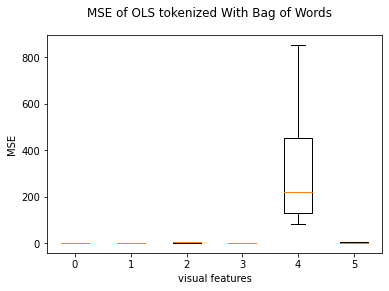

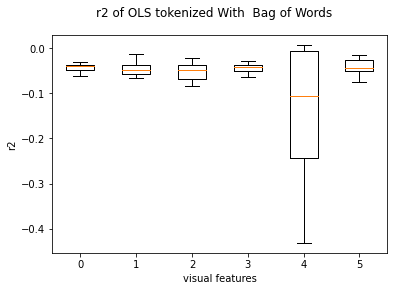

In [32]:

mse.T[0]

posit = range(mse.T.shape[1])
fig, ax = plt.subplots()
ax.boxplot(mse.T, positions=posit, showfliers=False)
plt.suptitle('MSE of OLS tokenized With Bag of Words')
plt.xlabel('visual features')
plt.ylabel('MSE')

plt.show()


fig, ax = plt.subplots()
ax.boxplot(r2.T, positions=posit, showfliers=False)
plt.suptitle('r2 of OLS tokenized With  Bag of Words')
plt.xlabel('visual features')
plt.ylabel('r2')

plt.show()

brightness---------------
Mean squared error: 1.22
Coefficient of determination: -0.16
contrast---------------
Mean squared error: 1.06
Coefficient of determination: -0.11
entropy---------------
Mean squared error: 1.14
Coefficient of determination: -0.14
face_count---------------
Mean squared error: 1.21
Coefficient of determination: -0.29
framerates---------------
Mean squared error: 0.80
Coefficient of determination: -0.07
number_of_pixels---------------
Mean squared error: 1.24
Coefficient of determination: -0.16
brightness---------------
Mean squared error: 1.18
Coefficient of determination: -0.20
contrast---------------
Mean squared error: 1.19
Coefficient of determination: -0.11
entropy---------------
Mean squared error: 1.19
Coefficient of determination: -0.25
face_count---------------
Mean squared error: 1.24
Coefficient of determination: -0.29
framerates---------------
Mean squared error: 0.48
Coefficient of determination: -0.16
number_of_pixels---------------
Mean squared er

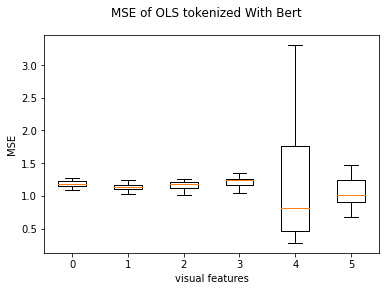

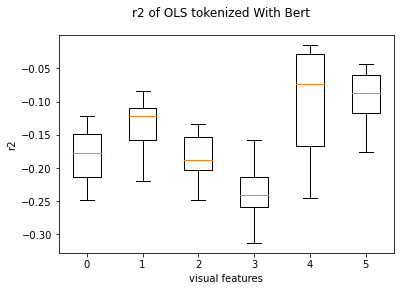

In [ ]:
# SVM Regression

import numpy as np

iteration = 20
mse = np.zeros((len(features), iteration))
r2 = np.zeros((len(features), iteration))

for i in range(0, iteration):
  for idx, f in enumerate(features):
    print(f+"---------------")
    X_train, X_test, Y_train, Y_test = data_split(tokenized_xr, normalized_df, f,i)
    # print(X_train.shape,Y_train.shape)
    # print(X_test.shape,Y_test.shape)

    svmReg = svm.SVR(kernel='poly')
    svmReg.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = svmReg.predict(X_test)
    
    mse[idx][i] = mean_squared_error(Y_test, Y_pred)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(Y_test, Y_pred))
    
    r2[idx][i] = r2_score(Y_test, Y_pred)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(Y_test, Y_pred))
    
posit = range(mse.T.shape[1])
fig, ax = plt.subplots()
ax.boxplot(mse.T, positions=posit, showfliers=False)
plt.suptitle('MSE of OLS tokenized With Bert')
plt.xlabel('visual features')
plt.ylabel('MSE')

plt.show()


fig, ax = plt.subplots()
ax.boxplot(r2.T, positions=posit, showfliers=False)
plt.suptitle('r2 of OLS tokenized With Bert')
plt.xlabel('visual features')
plt.ylabel('r2')

plt.show()

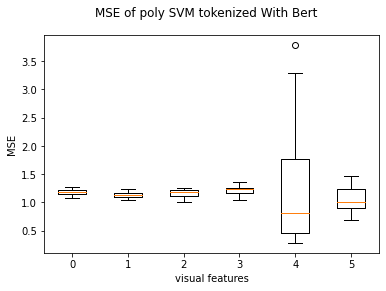

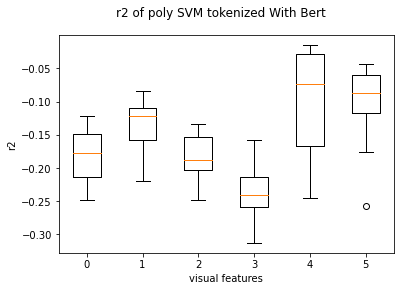

In [ ]:
posit = range(mse.T.shape[1])
fig, ax = plt.subplots()
ax.boxplot(mse.T, positions=posit)
plt.suptitle('MSE of poly SVM tokenized With Bert')
plt.xlabel('visual features')
plt.ylabel('MSE')

plt.show()


fig, ax = plt.subplots()
ax.boxplot(r2.T, positions=posit)
plt.suptitle('r2 of poly SVM tokenized With Bert')
plt.xlabel('visual features')
plt.ylabel('r2')

plt.show()

In [33]:
# Elastic-Net Regression param selection
from sklearn.linear_model import ElasticNetCV

regr = ElasticNetCV(cv=10, random_state=0)
regr.fit(X_train, Y_train)
print(regr.alpha_)
print(regr.l1_ratio_)


0.015703624871363196
0.5


In [ ]:
# Elastic-Net Regression

import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
iteration = 10
mse = np.zeros((len(features), iteration))
r2 = np.zeros((len(features), iteration))

for i in range(0, iteration):
  for idx, f in enumerate(features):
    print(f+"---------------")

    X_train, X_test, Y_train, Y_test = data_split(tokenized_xr, normalized_df, f,i, 0.2)
    regr = ElasticNetCV(cv=5, random_state=0)
    regr.fit(X_train, Y_train)
    # print(X_train.shape,Y_train.shape)
    # print(X_test.shape,Y_test.shape)
    elasticNet = ElasticNet(alpha=regr.alpha_, l1_ratio=regr.l1_ratio_)
    elasticNet.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = elasticNet.predict(X_test)
    
    mse[idx][i] = mean_squared_error(Y_test, Y_pred)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(Y_test, Y_pred))
    
    r2[idx][i] = r2_score(Y_test, Y_pred)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(Y_test, Y_pred))
    

brightness---------------
Mean squared error: 1.05
Coefficient of determination: -0.00
contrast---------------
Mean squared error: 0.95
Coefficient of determination: -0.00
entropy---------------
Mean squared error: 1.00
Coefficient of determination: -0.00
face_count---------------
Mean squared error: 0.95
Coefficient of determination: -0.01
framerates---------------
Mean squared error: 0.74
Coefficient of determination: -0.00
number_of_pixels---------------
Mean squared error: 1.07
Coefficient of determination: -0.00
brightness---------------
Mean squared error: 0.98
Coefficient of determination: -0.00
contrast---------------
Mean squared error: 1.08
Coefficient of determination: -0.00
entropy---------------
Mean squared error: 0.96
Coefficient of determination: -0.00
face_count---------------
Mean squared error: 0.96
Coefficient of determination: -0.00
framerates---------------
Mean squared error: 0.41
Coefficient of determination: -0.00
number_of_pixels---------------
Mean squared er

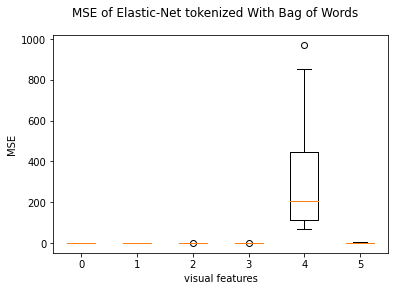

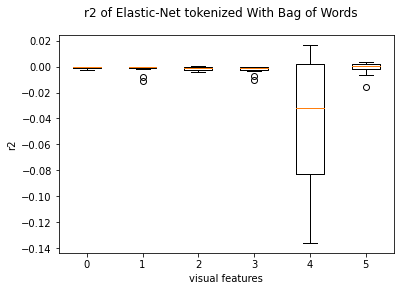

In [37]:
posit = range(mse.T.shape[1])
fig, ax = plt.subplots()
ax.boxplot(mse.T, positions=posit)
plt.suptitle('MSE of Elastic-Net tokenized With Bag of Words')
plt.xlabel('visual features')
plt.ylabel('MSE')
plt.show()


fig, ax = plt.subplots()
ax.boxplot(r2.T, positions=posit)
plt.suptitle('r2 of Elastic-Net tokenized With Bag of Words')
plt.xlabel('visual features')
plt.ylabel('r2')

plt.show()




brightness---------------
Mean squared error: 1.05
Coefficient of determination: -0.00


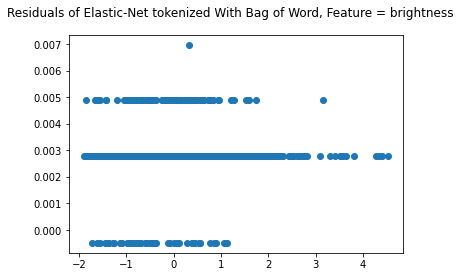

contrast---------------
Mean squared error: 0.95
Coefficient of determination: -0.00


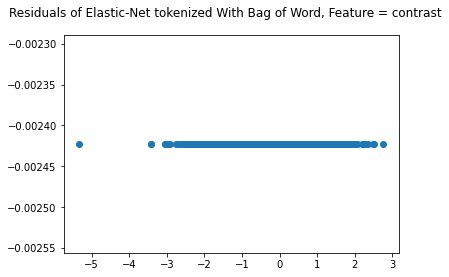

entropy---------------
Mean squared error: 1.00
Coefficient of determination: -0.00


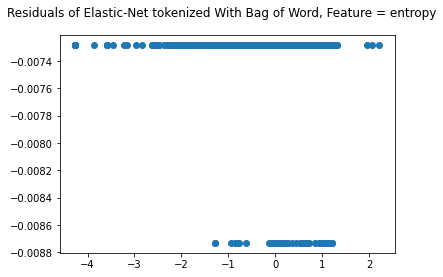

face_count---------------
Mean squared error: 0.95
Coefficient of determination: -0.01


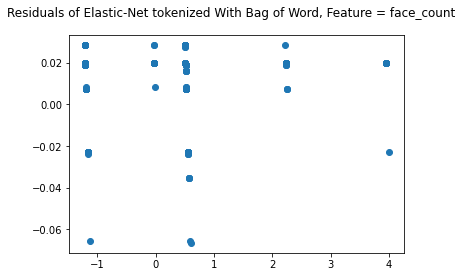

framerates---------------
Mean squared error: 0.75
Coefficient of determination: -0.01


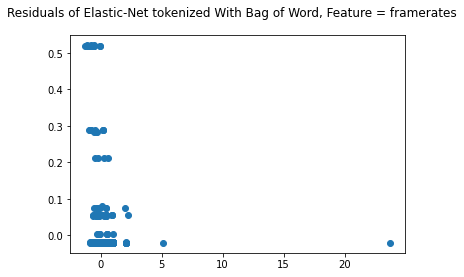

number_of_pixels---------------
Mean squared error: 1.07
Coefficient of determination: 0.00


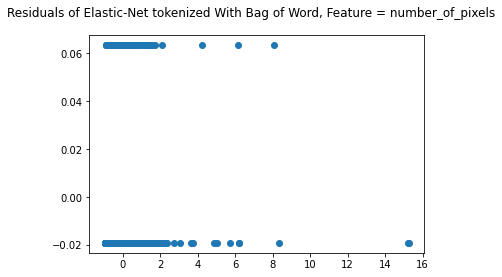

In [39]:
# Elastic-Net Regression Residual

import numpy as np
from sklearn.linear_model import ElasticNet
iteration = 1
mse = np.zeros((len(features), iteration))
r2 = np.zeros((len(features), iteration))

for i in range(0, iteration):
  for idx, f in enumerate(features):
    print(f+"---------------")
    X_train, X_test, Y_train, Y_test = data_split(tokenized_xr, normalized_df, f,i)
    # print(X_train.shape,Y_train.shape)
    # print(X_test.shape,Y_test.shape)
    elasticNet = ElasticNet(alpha=0.012348317365120482, l1_ratio=0.5)
    elasticNet.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = elasticNet.predict(X_test)
    
    mse[idx][i] = mean_squared_error(Y_test, Y_pred)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(Y_test, Y_pred))
    
    r2[idx][i] = r2_score(Y_test, Y_pred)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(Y_test, Y_pred))

    plt.suptitle('Residuals of Elastic-Net tokenized With Bag of Word, Feature = ' + f)
    plt.scatter(Y_test-Y_pred,Y_pred)
    plt.show()